```python
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# -----------------------------
# 설정
# -----------------------------
img_height = 32       # 셀 이미지 높이
img_width = 128       # 셀 이미지 폭
num_channels = 1      # 흑백 이미지
max_text_length = 10  # 한 셀 최대 글자 길이
characters = "0123456789DST"  # 인식할 문자 집합
num_classes = len(characters) + 1  # CTC용 blank 문자 추가

# 문자 → 인덱스
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(characters), oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=list(characters), oov_token="", invert=True)

# -----------------------------
# CNN + BiLSTM + CTC 모델
# -----------------------------
def build_model():
    input_img = layers.Input(shape=(img_height, img_width, num_channels), name='image')

    # CNN feature extractor
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_img)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    # CNN 출력 → 시퀀스 변환
    new_shape = ((img_width // 4), (img_height // 4) * 128)
    x = layers.Reshape(target_shape=new_shape)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # BiLSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    
    # Output layer
    output = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    model = models.Model(inputs=input_img, outputs=output)
    return model

# -----------------------------
# CTC Loss 계산용 레이어
# -----------------------------
class CTCLossLayer(layers.Layer):
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len,1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len,1), dtype='int64')

        loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

# -----------------------------
# 모델 컴파일
# -----------------------------
base_model = build_model()
labels = layers.Input(name='label', shape=(max_text_length,), dtype='float32')

output = CTCLossLayer()(labels, base_model.output)
model = models.Model(inputs=[base_model.input, labels], outputs=output)

model.compile(optimizer='adam')
model.summary()

# -----------------------------
# 데이터 준비 예시
# -----------------------------
# X: (num_samples, img_height, img_width, 1)
# y: (num_samples, max_text_length) 정수 인덱스
# 실제 학습 시에는 셀 이미지를 crop해서 resize 후 char_to_num으로 변환

# X_dummy = np.random.rand(32, img_height, img_width, 1).astype(np.float32)
# y_dummy = np.random.randint(0, num_classes, size=(32, max_text_length))

# model.fit([X_dummy, y_dummy], y_dummy, epochs=10, batch_size=8)

```python
from pandas import CategoricalDtype, read_csv, DataFrame
import pandas as pd
from math import floor, log10
from pathlib import Path
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
import tensorflow as tf
from matplotlib.pyplot import figure, axis, imshow, show
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

_1 = 'DEFEAT', 'DRAW', 'VICTORY'
_2 = {'TEAM': 'uint8', 'ROLE': CategoricalDtype(('ALL', 'TANK', 'DAMAGE', 'SUPPORT', 'NONE')), 'E': 'uint8', 'A': 'uint8',
      'D': 'uint8', 'DMG': 'uint16', 'H': 'uint16', 'MIT': 'uint16'}
_3 = (('TANK', 1), ('DAMAGE', 2), ('SUPPORT', 2))
_4 = 1, 2
_5 = [_6 for _6 in _2 if _6 not in {'TEAM', 'ROLE'}]
_7 = pd.concat((pd.read_csv(f'ROLE/{_8}.csv', index_col=0, dtype=_2) for _8 in _1), keys=_1, names=('RESULT',))
_7.dropna(inplace=True)


def _9(_10):
    _11 = {_12: [] for _12 in _2}
    for _13 in _4:
        _14 = _10[_10['TEAM'] == _13]
        for _15, _16 in _3:
            for _17 in range(_16 - sum(_14['ROLE'] == _15)):
                _11['TEAM'].append(_13)
                _11['ROLE'].append(_15)
                for _18 in _5:
                    _11[_18].append(0)
    return DataFrame(_11).astype(_2)


_19 = pd.concat([_7, _7.groupby(level=(0, 1)).apply(_9)])
_19.sort_values(['RESULT', 'INDEX', 'TEAM', 'ROLE'], inplace=True)
_20 = DataFrame()
_20['TEAM'] = _19['TEAM'] - 1
_20['ROLE'] = _19['ROLE'].cat.codes.astype('uint8')
for _21 in _5:
    for _22 in range(floor(log10(_19[_21].max())), -1, -1):
        _20[f'{_21}{_22}'] = (_19[_21] // 10 ** _22 % 10).astype('uint8')
_23 = tuple(_20.to_numpy().reshape(-1, 230).T)


def _24(_25, _26):
    _27 = decode_png(read_file(_25), 1)[230:930, 530:1370]
    _28 = resize(tf.concat(
        [_27[:, :40], _27[:, 390:420], _27[:, 450:480], _27[:, 500:530], _27[:, 570:640], _27[:, 670:740],
         _27[:, 770:]], 1), (300, 300)) / 255
    return _28, _26


_29 = sorted(map(str, Path().rglob('*.png')))
_30 = len(_23[0])
_31 = Dataset.from_tensor_slices((_29, _23)).map(_24, AUTOTUNE).shuffle(_30)
_32 = int(_30 * .9)
_33 = _31.take(_32).batch(32).prefetch(AUTOTUNE)
_34 = _31.skip(_32).batch(32).prefetch(AUTOTUNE)
for _35, _36 in _33.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(_35[0], 'gray')
    show()
    print(*(_37[0].numpy() for _37 in _36), sep='')
clear_session()
_38 = Input(_35.shape[1:])
_39 = Conv2D(32, (3, 3), activation='relu')(_38)
_40 = MaxPooling2D()(_39)
_41 = Conv2D(64, (3, 3), activation='relu')(_40)
_42 = MaxPooling2D()(_41)
_43 = Flatten()(_42)
_44 = _20.nunique()
_45 = Dense(128, 'relu')(_43)
_46 = tuple(Dense(_44[_47], 'softmax', name=f'{_47}_{_48}')(_45) for _48 in range(10) for _47 in _44.index)
_49 = Model(inputs=_38, outputs=_46)
_49.compile('SGD', 'sparse_categorical_crossentropy', metrics=['accuracy'] * len(_46))
_50 = _49.fit(_33, epochs=1000, callbacks=EarlyStopping(patience=10, restore_best_weights=True), validation_data=_34)

In [4]:
import pandas as pd
from pandas import CategoricalDtype, read_csv

file_keys = ('DE', 'DR', 'V')
to_int = lambda value: int(value) if value else 0
to_int_with_commas = lambda value: int(value.replace(',', '')) if value else 0
converters = {
    'T': lambda v: int(v) if v else 1,
    'R': lambda v: v if v else 'A',
    'E': to_int,
    'A': to_int,
    'DE': to_int,
    'DA': to_int_with_commas,
    'H': to_int_with_commas,
    'M': to_int_with_commas,
}
dtypes = {
    'T': CategoricalDtype((1, 2)),
    'R': CategoricalDtype(('A', 'T', 'D', 'S')),
    'E': 'uint8',
    'A': 'uint8',
    'DE': 'uint8',
    'DA': 'uint16',
    'H': 'uint16',
    'M': 'uint16',
}
df = pd.concat((read_csv(f'R/{key}.csv', index_col=0, converters=converters).astype(dtypes, False) for key in file_keys), keys=file_keys, names=('RE',))
df

T  R   E  A  DE    DA     H     M
RE I                                     
DE 1    1  T   0  0   8  2947  1425  4611
   1    1  D   1  0   3  1818     0   650
   1    1  D   2  0   7  4735   487   308
   1    1  S   1  0   3  2078  2748     0
   1    1  S   1  1   3   269  5848   189
...    .. ..  .. ..  ..   ...   ...   ...
V  467  2  T   7  2   4  6453     0  9665
   467  2  D  10  0   5  6272    62  1417
   467  2  D   6  1   7  5267    78    76
   467  2  S   5  1   6  4602  8211   716
   467  2  S   2  5   7  1979  7396   329

[9110 rows x 8 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9110 entries, ('DE', np.int64(1)) to ('V', np.int64(467))
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   T       9110 non-null   category
 1   R       9110 non-null   category
 2   E       9110 non-null   uint8   
 3   A       9110 non-null   uint8   
 4   DE      9110 non-null   uint8   
 5   DA      9110 non-null   uint16  
 6   H       9110 non-null   uint16  
 7   M       9110 non-null   uint16  
dtypes: category(2), uint16(3), uint8(3)
memory usage: 144.9+ KB


In [6]:
df['R'].value_counts()

R
D    3618
S    3616
T    1808
A      68
Name: count, dtype: int64

In [7]:
df_numpy = df.to_numpy()
df_numpy[:, 0] = df['T'].cat.codes.to_numpy('uint8')
df_numpy[:, 1] = df['R'].cat.codes.to_numpy('uint8')
numeric_max = df.iloc[:, 2:].to_numpy().max(0)
df_numpy[:, 2:] /= numeric_max
df_numpy = df_numpy.astype('float32', copy=False)
df_numpy.shape

(9110, 8)

In [8]:
# --- NumPy 배열로 변환 ---
df_array = tuple(df_numpy.reshape(-1, len(df.columns) * 10).T)
len(df_array)

80

2025-11-17 03:48:50.503684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763351330.688486      29 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763351330.750580      29 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763351331.263920      29 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763351331.263953      29 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763351331.263955      29 computation_placer.cc:177] computation placer alr

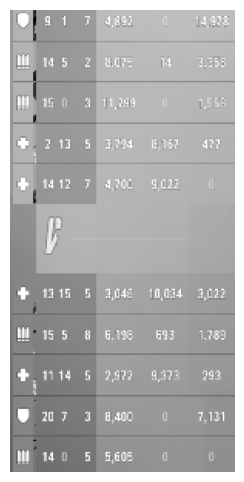

0.0 1.0 0.15789473 0.016129032 0.3043478 0.16349174 0.0 0.43666366 0.0 2.0 0.24561404 0.08064516 0.08695652 0.2698683 0.0005299217 0.09789802 0.0 2.0 0.2631579 0.0 0.13043478 0.39432526 0.0 0.04536311 0.0 3.0 0.03508772 0.20967741 0.2173913 0.12679633 0.3091336 0.0139063 0.0 3.0 0.24561404 0.19354838 0.3043478 0.15707506 0.34149665 0.0 1.0 3.0 0.22807017 0.24193548 0.2173913 0.101798005 0.3798024 0.088102385 1.0 2.0 0.2631579 0.08064516 0.3478261 0.20713855 0.026231121 0.052155916 1.0 3.0 0.19298245 0.22580644 0.2173913 0.09932491 0.35478255 0.008542025 1.0 1.0 0.3508772 0.11290322 0.13043478 0.2807299 0.0 0.20789482 1.0 2.0 0.24561404 0.0 0.2173913 0.18732037 0.0 0.0


2025-11-17 03:49:00.436228: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
from pathlib import Path
import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
from matplotlib.pyplot import figure, axis, imshow, show


# ==========================
# 이미지 전처리 함수
# ==========================

def preprocess_image(path, label):
    """PNG 이미지 파일을 읽고 필요한 부분을 추출 및 리사이즈."""
    image = decode_png(read_file(path), channels=1)[230:930, 530:1370]
    # 필요한 HUD 영역만 선택
    hud_parts = [
        image[:, :40], image[:, 390:420], image[:, 450:480],
        image[:, 500:530], image[:, 570:640], image[:, 670:740], image[:, 770:]
    ]
    cropped = tf.concat(hud_parts, axis=1)
    resized = resize(cropped, (300, 146)) / 255.0
    return resized, label


# ==========================
# Dataset 생성
# ==========================

image_paths = sorted(map(str, Path().rglob('*.png')))
data_count = len(df_array)

dataset = (
    Dataset.from_tensor_slices((image_paths, df_array))
    .map(preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(data_count)
)

train_size = int(data_count * 0.9)
train_ds = dataset.take(train_size).batch(32).prefetch(AUTOTUNE)
val_ds = dataset.skip(train_size).batch(32).prefetch(AUTOTUNE)

# ==========================
# 샘플 시각화
# ==========================

for x_batch, y_batch in train_ds.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(*[tensor[0].numpy() for tensor in y_batch], sep=' ')

In [10]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import AdamW

clear_session()

# ==========================
# CNN 백본 모델 정의
# ==========================

input_tensor = Input(shape=x_batch.shape[1:])

x = Conv2D(32, (3, 3), padding='same', use_bias=False)(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(256, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# ==========================
# 다중 출력층 생성
# ==========================

unique_counts = df.nunique()
outputs = []
for i in range(10):
    outputs.append(Dense(1, name=f'T_{i}')(x))
    outputs.append(Dense(4, name=f'R_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'E_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'A_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'DE_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'DA_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'H_{i}')(x))
    outputs.append(Dense(1, 'linear', name=f'M_{i}')(x))
model = Model(inputs=input_tensor, outputs=outputs)

# ==========================
# 모델 컴파일
# ==========================

loss = {}
for i in range(10):
    loss[f'T_{i}'] = BinaryCrossentropy(from_logits=True)
    loss[f'R_{i}'] = SparseCategoricalCrossentropy(from_logits=True)
    loss[f'E_{i}'] = 'mse'
    loss[f'A_{i}'] = 'mse'
    loss[f'DE_{i}'] = 'mse'
    loss[f'DA_{i}'] = 'mse'
    loss[f'H_{i}'] = 'mse'
    loss[f'M_{i}'] = 'mse'
metrics = {}
for i in range(10):
    metrics[f'T_{i}'] = 'accuracy'
    metrics[f'R_{i}'] = 'accuracy'
    metrics[f'E_{i}'] = 'mse'
    metrics[f'A_{i}'] = 'mse'
    metrics[f'DE_{i}'] = 'mse'
    metrics[f'DA_{i}'] = 'mse'
    metrics[f'H_{i}'] = 'mse'
    metrics[f'M_{i}'] = 'mse'
model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss=loss,
    metrics=metrics
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 146,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 146,  │        288 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 300, 146,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 300, 146,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 73,   │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 73,   │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 73,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 150, 73,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 36,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 36,    │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 36,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 75, 36,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 37, 18,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 37, 18,    │    294,912 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 18,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 37, 18,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 18, 9,     │          0 │ re_lu_3[0][0]   

 Total params: 21,783,054 (83.10 MB)

 Trainable params: 21,782,094 (83.09 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
from tensorflow.keras.callbacks import Callback, EarlyStopping
from numpy import mean


# ==========================
# 모델 학습
# ==========================

class TypeAveragingLogger(Callback):
    def __init__(self, output_types=('T', 'R', 'E', 'A', 'DE', 'DA', 'H', 'M')):
        super().__init__()
        self.output_types = output_types

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f'\n=== 평균 손실 및 정확도 (Epoch {epoch + 1}) ===')

        for t in self.output_types:
            # 각 타입별 키 필터링
            loss_keys = [k for k in logs.keys() if k.startswith(f'val_{t}_') and k.endswith('_loss')]
            acc_keys = [k for k in logs.keys() if k.startswith(f'val_{t}_') and ('accuracy' in k or 'acc' in k)]

            # 평균 계산
            if loss_keys:
                mean_loss = mean([logs[k] for k in loss_keys])
                print(f' {t} 평균 val_loss: {mean_loss:.4f}')
            if acc_keys:
                mean_acc = mean([logs[k] for k in acc_keys])
                print(f' {t} 평균 val_accuracy: {mean_acc:.4f}')

        print('=' * 40)


# EarlyStopping 콜백 설정
early_stop = EarlyStopping(  # 검증 손실 기준으로 모니터링
    patience=8,  # patience 동안 개선 없으면 종료
    verbose=1,
    restore_best_weights=True  # 가장 성능 좋았던 가중치로 복원
)

# 학습
history = model.fit(
    train_ds,
    epochs=128,
    verbose=0,
    validation_data=val_ds,
    callbacks=(TypeAveragingLogger(), early_stop)
)

I0000 00:00:1763272712.907271     125 service.cc:152] XLA service 0x789364006d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763272712.907341     125 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-11-16 05:58:33.700343: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763272716.457998     125 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763272728.418681     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-16 05:59:07.422156: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1153_0', 44 bytes spill stores, 44 bytes spill loads

2025-11-16 05:59:07.684842: I ex


=== 평균 손실 및 정확도 (Epoch 1) ===
 T 평균 val_loss: 0.6892
 T 평균 val_accuracy: 0.6943
 R 평균 val_loss: 1.3821
 R 평균 val_accuracy: 0.2743
 E 평균 val_loss: 0.0948
 A 평균 val_loss: 0.0301
 DE 평균 val_loss: 0.1076
 DA 평균 val_loss: 0.0778
 H 평균 val_loss: 0.0538
 M 평균 val_loss: 0.0205

=== 평균 손실 및 정확도 (Epoch 2) ===
 T 평균 val_loss: 0.6928
 T 평균 val_accuracy: 0.4452
 R 평균 val_loss: 1.3853
 R 평균 val_accuracy: 0.2754
 E 평균 val_loss: 0.0934
 A 평균 val_loss: 0.0298
 DE 평균 val_loss: 0.1028
 DA 평균 val_loss: 0.0753
 H 평균 val_loss: 0.0531
 M 평균 val_loss: 0.0212

=== 평균 손실 및 정확도 (Epoch 3) ===
 T 평균 val_loss: 0.6934
 T 평균 val_accuracy: 0.3963
 R 평균 val_loss: 1.3848
 R 평균 val_accuracy: 0.2722
 E 평균 val_loss: 0.0930
 A 평균 val_loss: 0.0302
 DE 평균 val_loss: 0.1039
 DA 평균 val_loss: 0.0752
 H 평균 val_loss: 0.0541
 M 평균 val_loss: 0.0203

=== 평균 손실 및 정확도 (Epoch 4) ===
 T 평균 val_loss: 0.6929
 T 평균 val_accuracy: 0.4337
 R 평균 val_loss: 1.3838
 R 평균 val_accuracy: 0.6536
 E 평균 val_loss: 0.0931
 A 평균 val_loss: 0.0302
 DE 평균 val

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


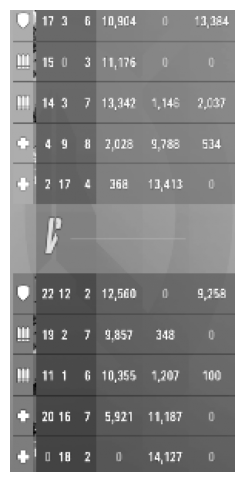

0.0 1.0 0.2982456 0.048387095 0.26086956 0.36441416 0.0 0.39019272 0.0 2.0 0.2631579 0.0 0.13043478 0.37350443 0.0 0.0 0.0 2.0 0.24561404 0.048387095 0.3043478 0.44589266 0.043377873 0.059386022 0.0 3.0 0.07017544 0.14516129 0.3478261 0.06777622 0.37049094 0.015568059 0.0 3.0 0.03508772 0.27419356 0.17391305 0.012298644 0.50770277 0.0 1.0 1.0 0.3859649 0.19354838 0.08695652 0.41975805 0.0 0.26990467 1.0 2.0 0.33333334 0.032258064 0.3043478 0.32942316 0.013172338 0.0 1.0 2.0 0.19298245 0.016129032 0.26086956 0.34606645 0.045686815 0.0029153668 1.0 3.0 0.3508772 0.2580645 0.3043478 0.19788116 0.42344525 0.0 1.0 3.0 0.0 0.29032257 0.08695652 0.0 0.53472877 0.0


2025-11-16 06:31:24.817139: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
from numpy import array

for x_batch, y_batch in val_ds.take(1):
    x_sample = x_batch[0:1]
    y_sample = tuple(y[0] for y in y_batch)
    y_pred = model.predict(x_sample)
    figure(figsize=(6, 6))
    axis('off')
    imshow(x_batch[0], 'gray')
    show()
    print(*[tensor[0].numpy() for tensor in y_batch], sep=' ')

In [15]:
import numpy as np

In [16]:
y_sample_ = (array(y_sample).reshape(-1, 8) * ([1, 1] + numeric_max.tolist())).round().astype('uint16')
y_sample_

array([[    0,     1,    17,     3,     6, 10904,     0, 13384],
       [    0,     2,    15,     0,     3, 11176,     0,     0],
       [    0,     2,    14,     3,     7, 13342,  1146,  2037],
       [    0,     3,     4,     9,     8,  2028,  9788,   534],
       [    0,     3,     2,    17,     4,   368, 13413,     0],
       [    1,     1,    22,    12,     2, 12560,     0,  9258],
       [    1,     2,    19,     2,     7,  9857,   348,     0],
       [    1,     2,    11,     1,     6, 10355,  1207,   100],
       [    1,     3,    20,    16,     7,  5921, 11187,     0],
       [    1,     3,     0,    18,     2,     0, 14127,     0]],
      dtype=uint16)

In [17]:
print(f'T R  E  A DE  DA    H    M')
for i in range(10):
    print(f'{int(y_pred[0 + i * 8][0][0] >= 0.5):1d}', end=' ')
    print(f'{y_pred[1 + i * 8][0].argmax():1d}', end=' ')
    print(f'{int((y_pred[2 + i * 8][0][0] * numeric_max[0]).round()):2d}', end=' ')
    print(f'{int((y_pred[3 + i * 8][0][0] * numeric_max[1]).round()):2d}', end=' ')
    print(f'{int((y_pred[4 + i * 8][0][0] * numeric_max[2]).round()):1d}', end=' ')
    print(f'{int((y_pred[5 + i * 8][0][0] * numeric_max[3]).round()):4d}', end=' ')
    print(f'{int((y_pred[6 + i * 8][0][0] * numeric_max[4]).round()):4d}', end=' ')
    print(f'{int((y_pred[7 + i * 8][0][0] * numeric_max[5]).round()):4d}', end=' ')
    print()

T R  E  A DE  DA    H    M
0 1  2  1 1 1034  151 1213 
0 2  1  2 0 1280 -127 -715 
0 2  2  1 1  116    3 -121 
0 3  1  1 1  329  498  121 
0 3  0  1 1  189  864 -471 
1 1  3  1 1 1161  -20  488 
1 2  1  1 0 1063  325   -4 
1 2  1 -1 1 1419  630 -297 
1 3  1  2 1  158  777 -338 
1 3  2  3 1  180 1135 1589 


자릿수 나눠서 학습해 보자! 가능성이 있다!